# Analyze FIT file: optical HR sensor vs. chest strap
Use case: check the accuracy of built-in heart rate sensor (or a paired sensor) using external (unpaired) ANT+ sensor as allegedly more precise reference.

Prerequisites:
- Garmin watch with optical HRM
- ANT+ HRM installed (https://apps.garmin.com/apps/7c83d402-4b68-4f0a-b167-7139788a19b3)
- Activity configured with ANT+ HRM data field in a data screen (https://flocsy.eu/projects/garmin/ANT+HRM/FAQ.md)
- Activity recorded with optical HRM and ANT+ HRM
- Activity FIT file converted to CSV (https://developer.garmin.com/fit/fitcsvtool/windows/)

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

FIT_EPOCH_S = 631065600 # Garmin FIT SDK /py/garmin_fit_sdk/util.py

## Load and preprocess data

In [13]:
data = pd.read_csv('14036113189_ACTIVITY.csv')
data = data[['Type', 'Message', 'Field 1', 'Value 1', 'Field 4', 'Value 4', 'Field 8', 'Value 8']]

In [14]:
data = data[(data['Type']=='Data') & (data['Message']=='record')]
data.head()

,Type,Message,Field 1,Value 1,Field 4,Value 4,Field 8,Value 8
41,Data,record,timestamp,1077293965,heart_rate,72.0,NaN,NaN
44,Data,record,timestamp,1077293966,heart_rate,72.0,NaN,NaN
46,Data,record,timestamp,1077293967,heart_rate,72.0,ANT_HR,71
48,Data,record,timestamp,1077293968,heart_rate,73.0,ANT_HR,71
50,Data,record,timestamp,1077293969,heart_rate,73.0,ANT_HR,71


In [15]:
data = data[['Value 1', 'Value 4', 'Value 8']] \
    .rename(columns={'Value 1': 'timestamp', 'Value 4': 'Optical_HR', 'Value 8': 'ANT_HR'}) \
    .dropna()

data['ANT_HR'] = data['ANT_HR'].astype(float)
data['diff'] = (data['Optical_HR'] - data['ANT_HR'])
data['timestamp'] = (data['timestamp'].astype(int) + FIT_EPOCH_S).apply(pd.Timestamp.utcfromtimestamp)
data = data.set_index('timestamp')
data.head()

C:\Users\ag\AppData\Local\Temp/ipykernel_29668/1918157952.py:7: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  data['timestamp'] = (data['timestamp'].astype(int) + FIT_EPOCH_S).apply(pd.Timestamp.utcfromtimestamp)


,Optical_HR,ANT_HR,diff
timestamp,,,
2024-02-19 16:19:27,72.0,71.0,1.0
2024-02-19 16:19:28,73.0,71.0,2.0
2024-02-19 16:19:29,73.0,71.0,2.0
2024-02-19 16:19:30,73.0,72.0,1.0
2024-02-19 16:19:31,73.0,73.0,0.0


In [16]:
def plot_linechart(hr1: pd.Series, hr2: pd.Series, diff: pd.Series):
    '''Plot sensors data and difference'''
    f, ax = plt.subplots(2, 1, squeeze=True, gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
    f.set_size_inches(20, 7)

    sns.lineplot(data=hr1, color='blue', label=hr1.name, ax = ax[0])
    sns.lineplot(data=hr2, color='red', label=hr2.name, ax = ax[0])
    ax[0].set_ylabel('bpm')
    ax[0].legend()
    sns.lineplot(data=diff.rename('Error, bpm'), ax=ax[1])
    ax[1].axhline(0, color='r', linestyle='--')
    line = ax[1].get_lines()
    plt.fill_between(line[0].get_xdata(), line[0].get_ydata(), [0]*len(diff), color='blue', alpha=.1)    


In [17]:
def plot_distribution(hr1: pd.Series, hr2: pd.Series, diff: pd.Series):
    '''Plot distribution of sensors data difference'''
    f, ax = plt.subplots(1, 3, squeeze=True)
    f.set_size_inches(20, 5)

    sns.scatterplot(data=pd.concat([hr1, hr2], axis='columns'), x=hr1.name, y=hr2.name, ax=ax[0])
    hr_min = hr1.min()
    hr_max = hr1.max()
    sns.lineplot(data=pd.DataFrame({hr1.name: [hr_min, hr_max], hr2.name: [hr_min, hr_max]}), x=hr1.name, y=hr2.name, color='r', linestyle='--', ax=ax[0])

    sns.histplot(data=diff.rename('Error, bpm'), ax=ax[1])
    ax[1].axvline(diff.mean(), color='r', linestyle='--', label=f'ME = {diff.mean():.2f}')
    ax[1].legend()

    sns.histplot(data=(diff / hr1 * 100).rename('Percentage error'), ax=ax[2])
    ax[2].axvline((diff / hr1 * 100).mean(), color='r', linestyle='--', label=f'MPE = {(diff / hr1 * 100).mean():.2f}')
    ax[2].legend()


In [18]:
def crosscorrelation_chart(hr1, hr2, lag=(-10, 10), ax=None) -> int:
    '''Plot correlation between sensors data at various delays, return best delay'''
    lags = list(range(*lag))
    correlations = [hr1.corr(hr2.shift(-lag)) for lag in lags]
    if ax is None:
        f, ax = plt.subplots()
    ax.set(xlabel='Delay, s', ylabel='Pearson r')
    maxcorr = lags[np.argmax(correlations)]
    ax.plot(lags, correlations, label=f'Peak @ {maxcorr} seconds')
    ax.axvline(maxcorr, color='r', linestyle='--')
    plt.legend()
    return maxcorr


In [19]:
def error_stats(hr1: pd.Series, hr2: pd.Series, diff: pd.Series):
    print(f'Duration: {hr1.index[-1] - hr1.index[0]}')
    print(f'Mean {hr1.name}: {hr1.mean():.2f}')
    print(f'Mean {hr2.name}: {hr2.mean():.2f}')
    print(f"MAPE = {(diff.abs() / hr1).mean() * 100:.2f}%")
    print(f"MAE = {diff.abs().mean():.2f} bpm")
    print(f"RMSE = {(diff**2).mean()**(1/2):.2f} bpm")
    print(f"Correlation = {hr1.corr(hr2, method='pearson'):.3f}")

## Visualize data

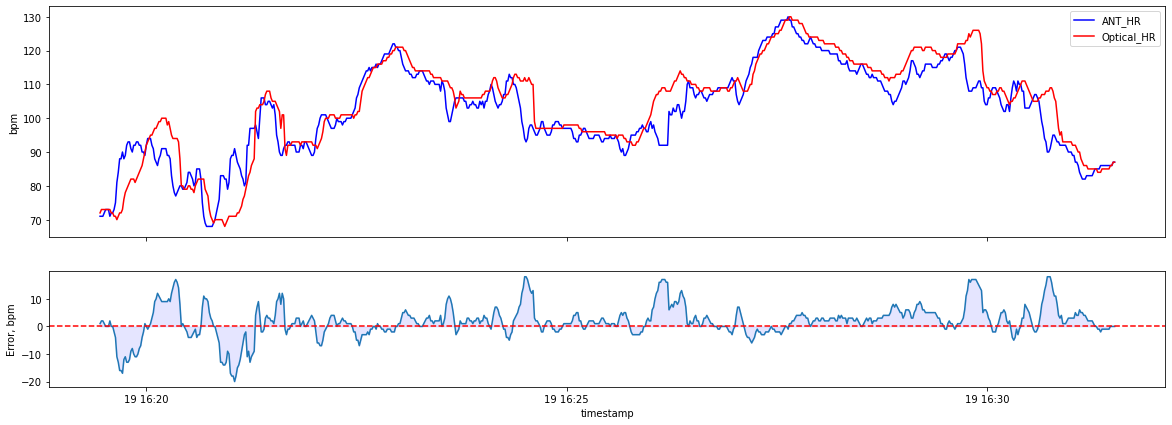

In [20]:
plot_linechart(data['ANT_HR'], data['Optical_HR'], data['diff'])

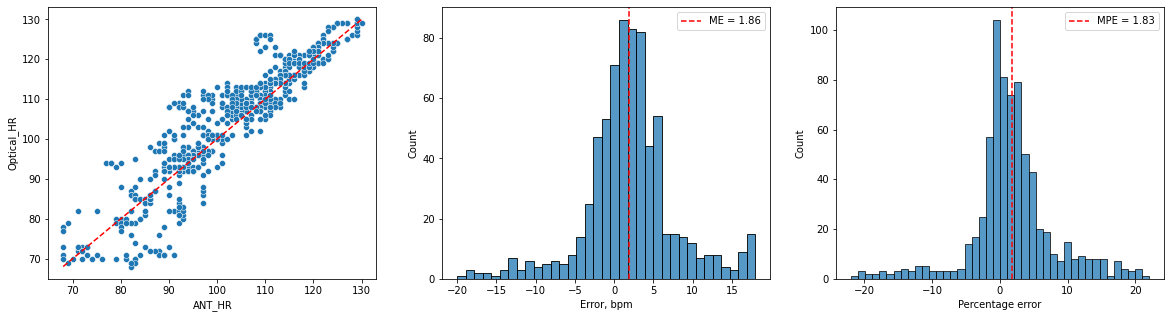

In [21]:
plot_distribution(data['ANT_HR'], data['Optical_HR'], data['diff'])

## Estimate if built-in sensor is "delayed"

Optical HRM data appears visually lagging behind chest strap

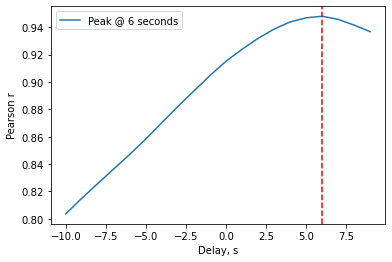

In [22]:
delay = crosscorrelation_chart(data['ANT_HR'], data['Optical_HR'])

## Repeat analysis with built-in sensor data delay-adjusted

In [23]:
data['Optical_HR_shifted'] = data['Optical_HR'].shift(-delay)
data['diff_shifted'] = (data['Optical_HR_shifted'] - data['ANT_HR'])
data_shifted = data.dropna()

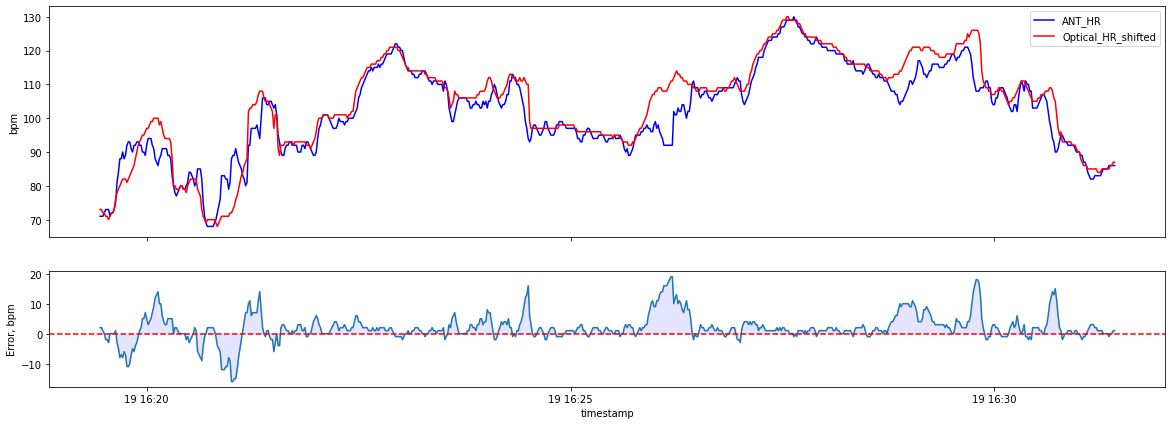

In [24]:
plot_linechart(data_shifted['ANT_HR'], data_shifted['Optical_HR_shifted'], data_shifted['diff_shifted'])

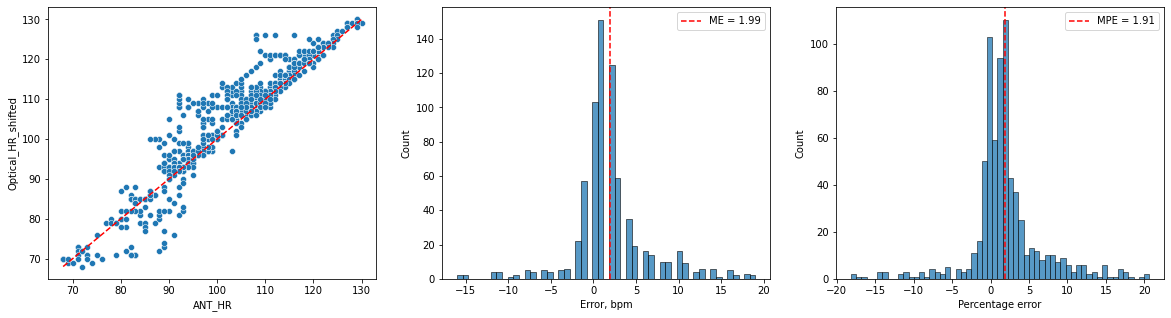

In [25]:
plot_distribution(data_shifted['ANT_HR'], data_shifted['Optical_HR_shifted'], data_shifted['diff_shifted'])

## Final stats

### Original data

In [26]:
error_stats(data['ANT_HR'], data['Optical_HR'], data['diff'])

Duration: 0 days 00:12:04
Mean ANT_HR: 102.04
Mean Optical_HR: 103.90
MAPE = 4.39%
MAE = 4.25 bpm
RMSE = 6.09 bpm
Correlation = 0.915


### Delay-adjusted data

In [27]:
error_stats(data_shifted['ANT_HR'], data_shifted['Optical_HR_shifted'], data_shifted['diff_shifted'])

Duration: 0 days 00:11:58
Mean ANT_HR: 102.17
Mean Optical_HR_shifted: 104.16
MAPE = 3.27%
MAE = 3.21 bpm
RMSE = 4.94 bpm
Correlation = 0.948
